# Sentiment Analysis Using Twitter Data

## Libraries

In [105]:
# General imports
import re
import pickle
import numpy as np
import pandas as pd
import time

# Plotting imports
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Warnings imports
import warnings
warnings.filterwarnings("ignore")

# Nltk imports
import nltk.corpus
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer

# Sklearn imports
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## Helper functions

**There are 2 helper functions:**

- A **barrier** function that prints a horizontal line to separate printed outputs.
- A **decontracted_all** function that uses regex to replace all contractions with their corresponding **expanded** form.
    - Note that the [**'s**] contraction can indicate possession **(eg The book is John's)** or be a contraction of the long-form **word + has/is** **(eg He's a good guy)**.
    - This can create a small error where possession is concerned since an expression like "**The book is John's**" will be turned into "**The book is John has/is**".
    - However, we accept this small error while text processing as it does not adversely affect sentiment and we expect the model to be robust enough to deal with it.

In [106]:
def barrier():
    print("\n <<<","-"*50,">>> \n")

def decontracted_all(phrase):
    phrase = re.sub(r"(can't)|(cant)", "can not", phrase)
    phrase = re.sub(r"(won't)|(wont)", "will not", phrase)
    phrase = re.sub(r"n't", " not", phrase)
    phrase = re.sub(r"'re", " are", phrase)
    phrase = re.sub(r"'s", " is", phrase)
    phrase = re.sub(r"'d", " would", phrase)
    phrase = re.sub(r"'ll", " will", phrase)
    phrase = re.sub(r"'ve", " have", phrase)
    phrase = re.sub(r"'m", " am", phrase)
    return phrase

In [107]:
# Example for decontracted_all
decontracted_all("""don't, isn't, won't, shouldn't, couldn't, wouldn't, aren't, doesn't, wasn't, weren't, hasn't,
                    haven't, hadn't, mustn't, didn't, mightn't, needn't, John's""")

'do not, is not, will not, should not, could not, would not, are not, does not, was not, were not, has not,\n                    have not, had not, must not, did not, might not, need not, John is'

**Note:**
- The above example shows how the **decontracted_all** function works for all contractions in the English language.

## Data import
**Introduction:**
- The dataset being used is the **sentiment140 dataset**.
- It contains 1,600,000 tweets extracted using the **Twitter API**.
- The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.

**The dataset contains the following features:**
1. **sentiment**: The polarity of the tweet: (0 = negative, 4 = positive).
2. **ids**: The id of the tweet.
3. **date**: The date of the tweet.
4. **flag**: The query of the tweet. If there is no query, then this value is NO_QUERY.
5. **user**: The user that tweeted.
6. **text**: The text of the tweet.

**Note:**
- We require only the **sentiment** and **text** fields, so we can discard the other features.
- Furthermore, we're changing the **sentiment** field so that it has new values to reflect the sentiment: (**0 = Negative, 1 = Positive**)
- The data file is too large to upload to the GitHub repository but is available at https://www.kaggle.com/datasets/kazanova/sentiment140

In [108]:
# Data import
df_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df_ENCODING = "ISO-8859-1"

# The path should be adjusted as needed to point to the csv file
df = pd.read_csv("data/data.csv", encoding=df_ENCODING , names=df_COLUMNS)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [109]:
# Replacing the values for better understanding
df["sentiment"] = df["sentiment"].replace(4,1)

In [110]:
# Drop duplicates, if any
print(df.shape)
print(df.drop_duplicates().shape)

(1600000, 6)
(1600000, 6)


**Note:**
- The dataset has the same shape both before and after the drop_duplicates function.
- This suggests that there are no tweets with exactly the same information from exactly the same users on exactly the same dates.

In [111]:
# Check for any skew in the values for the sentiments
df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

**Note:**
- The sentiments are perfectly split into both classes.
- There is no skew.

In [112]:
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [113]:
# Decontract all contractions in the text column
df["text"] = df["text"].apply(decontracted_all)

In [114]:
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can not update his Facebook b...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it is not behaving at all..."


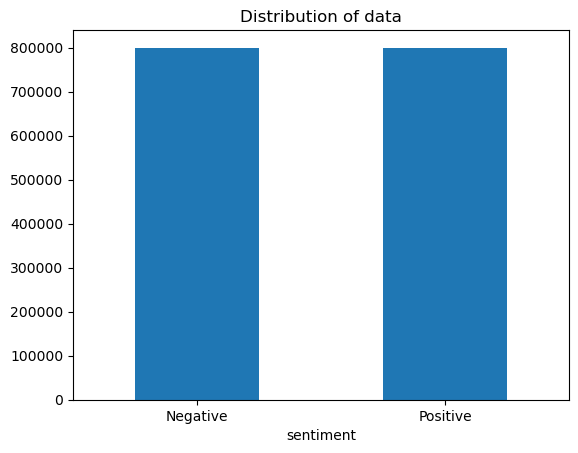

In [115]:
# Removing the unnecessary columns
df = df[["sentiment", "text"]]

# Plotting the distribution for sentiment count
ax = df.groupby("sentiment").count().plot(kind="bar", title="Distribution of data", legend=False)
ax.set_xticklabels(["Negative","Positive"], rotation=0)

# Storing data
text_list, sentiment_list = list(df["text"]), list(df["sentiment"])
text, sentiment = df["text"], df["sentiment"]

## Data wrangling
- Data wrangling in Natural Language Processing (NLP) largely involvesText Processing.
- Text Processing transforms text into a more pliable form for machine learning algorithms.

**The data wrangling steps taken are:**
1. Lower casing
2. Replacing URLs with the word "URL"
3. Replacing emojis eg: converting :) to EMOJIsmile
4. Replacing usernames with word "USER"
5. Replacing non-alphanumeric characters with a space
6. Removing consecutive letters eg:"Heyyyy" to "Heyy"
7. Lemmatization

**Note:**
- The removal of stop words is optionally available and commented out in the code below.
- Model tuning suggested that accuracy was worsened by the removal of stop words.
    - This is because stop words include words that indicate negation (eg can't, wouldn't, not, don't etc) which strongly affect sentiment.
- Consequently, I have opted to leave them **in** the corpus.

In [116]:
# Mapping of all emojis with their meanings
emojis = {":)":"smile", ":-)":"smile", ";d":"wink", ":-E":"vampire", ":(":"sad", 
          ":-(":"sad", ":-<":"sad", ":P":"raspberry", ":O":"surprised",
          ":-@":"shocked", ":@":"shocked", ":-$":"confused", ":\\":"annoyed", 
          ":#":"mute", ":X":"mute", ":^)":"smile", ":-&":"confused", "$_$":"greedy",
          "@@":"eyeroll", ":-!":"confused", ":-D":"smile", ":-0":"yell", "O.o":"confused",
          "<(-_-)>":"robot", "d[-_-]b":"dj", ":'-)":"sadsmile", ";)":"wink", 
          ";-)":"wink", "O:-)":"angel","O*-)":"angel","(:-D":"gossip", "=^.^=":"cat"}

# Stopwords
stopwords = nltk.corpus.stopwords.words("english")

In [117]:
# Function that carries out all pre-processing steps
def preprocess(text_data):
    processed_text = []
    
    # Create lemmatizer
    word_lemm = WordNetLemmatizer()
    
    # Defining regex patterns
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www.)[^ ]*)"
    user_pattern = r"@[^\s]+"
    alpha_pattern = r"[^a-zA-Z0-9]"
    sequence_pattern = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"
    
    # Cleaning
    for tweet in text_data:
        # Lower case
        tweet = tweet.lower()
        # Replace all URls with "URL"
        tweet = re.sub(url_pattern, "URL", tweet)
        # Replace all emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME with "USER"
        tweet = re.sub(user_pattern, "USER", tweet)       
        # Replace all non-alphanumeric characters
        tweet = re.sub(alpha_pattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letters
        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)
        # Lemmatizing
        words = tweet.split()
        words_cleaned = []
        
        for word in words:
            words_cleaned.append(word_lemm.lemmatize(word))
        
        # # OPTIONAL - Stop word removal
        # words_cleaned = [i for i in words_cleaned if i not in stopwords]
        
        # Re-combination
        processed_text.append(" ".join(words_cleaned))
    
    return processed_text

In [118]:
# Timing
start = time.time()
processedtext = preprocess(df["text"])
print(f"Time Taken: {round(time.time() - start)} seconds.")

Time Taken: 138 seconds.


## EDA

In [119]:
# Separate the negative and positive sentiment tweets
text_negative = text[sentiment == 0]
text_positive = text[sentiment == 1]

### Word-cloud for negative tweets

**Note:**
- The wordcloud code below takes a significant amount of time to run due to the size of the dataset. The image was generated once, saved and then referenced in the notebook using markdown.
- The code can be uncommented and re-run if needed

In [137]:
# plt.figure(figsize=(20,20))
# wc = WordCloud(max_words= 1000, width=1600, height=800, collocations=False).generate(" ".join(text_negative))
# plt.imshow(wc)
# plt.show()

![word cloud negative](data/word_cloud_negative.png)

### Word-cloud for positive tweets

**Note:**
- The wordcloud code below takes a significant amount of time to run due to the size of the dataset. The image was generated once, saved and then referenced in the notebook using markdown.
- The code can be uncommented and re-run if needed

In [138]:
# plt.figure(figsize = (20, 20))
# wc = WordCloud(max_words=1000 , width=1600 , height=800, collocations=False).generate(" ".join(text_positive))
# plt.imshow(wc)
# plt.show()

![word cloud positive](data/word_cloud_positive.png)

## Pre-processing

### Splitting the data

In [122]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size=0.2, random_state=0)

In [123]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1280000
320000
1280000
320000


### Transforming the data

In [124]:
# Use the tfidfvectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

**NOTE:**
- We set `ngram_range` to (1,2) meaning we ue single words as well as bi-grams in our model.

In [125]:
print("No. of feature_words: ", len(vectorizer.get_feature_names_out()))

No. of feature_words:  500000


In [126]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [127]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1280000, 500000)
(320000, 500000)
(1280000,)
(320000,)


**NOTE:**
- **Tf-idf** or **Term Frequency Inverse Document Frequency** will weight the words according to their importance in the corpus.
- Words that are frequent in one document but not in the corpus as a whole will be weighted favorably over words that are common to all documents.

## Modelling
**The following models will be used:**
- Bernoulli Naive Bayes (BernoulliNB)
- Linear Support Vector Classification (LinearSVC)
- Logistic Regression (LR)

**Furthermore:**
- Since our data is not **skewed**, we will choose **accuracy** as our evaluation metric.
- We will plot the **confusion matrix** to get an understanding of how our model is performing on both classes.

### Function to evaluate model function

In [128]:
# Create function to evaluate model
def model_evaluate(model):
    # Predict values for test df
    y_pred = model.predict(X_test)
    
    # Print the evaluation metrics for the df
    print(classification_report(y_test, y_pred))
    
    barrier()
    
    # Compute and plot the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    categories  = ["Negative", "Positive"]
    group_names = ["True Neg", "False Pos", "False Neg","True Pos"]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, cmap="Blues", fmt="", xticklabels=categories, yticklabels=categories)
    
    plt.xlabel("Predicted values", fontdict={"size":14}, labelpad=10)
    plt.ylabel("Actual values"   , fontdict={"size":14}, labelpad=10)
    plt.title ("Confusion Matrix", fontdict={"size":18}, pad=20)

### BernoulliNB model

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    159815
           1       0.79      0.81      0.80    160185

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000


 <<< -------------------------------------------------- >>> 



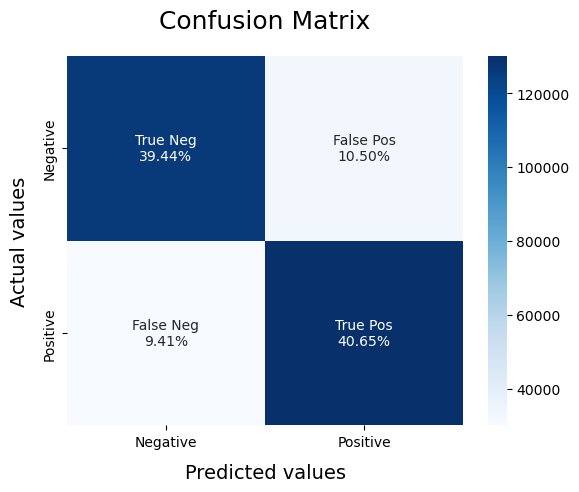

In [129]:
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, y_train)
model_evaluate(BNBmodel)

In [130]:
print(BNBmodel.score(X_train, y_train))
print(BNBmodel.score(X_test, y_test))

0.82738984375
0.800946875


### LinearSVC model

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159815
           1       0.81      0.82      0.82    160185

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000


 <<< -------------------------------------------------- >>> 



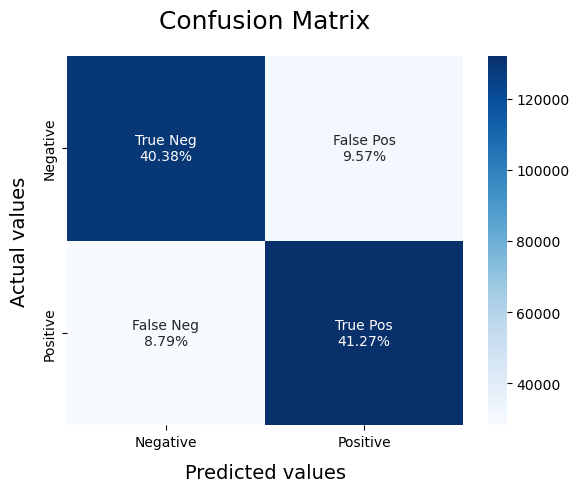

In [131]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate(SVCmodel)

In [132]:
print(SVCmodel.score(X_train, y_train))
print(SVCmodel.score(X_test, y_test))

0.909940625
0.81646875


### Logistic Regression model

              precision    recall  f1-score   support

           0       0.83      0.82      0.83    159815
           1       0.82      0.84      0.83    160185

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000


 <<< -------------------------------------------------- >>> 



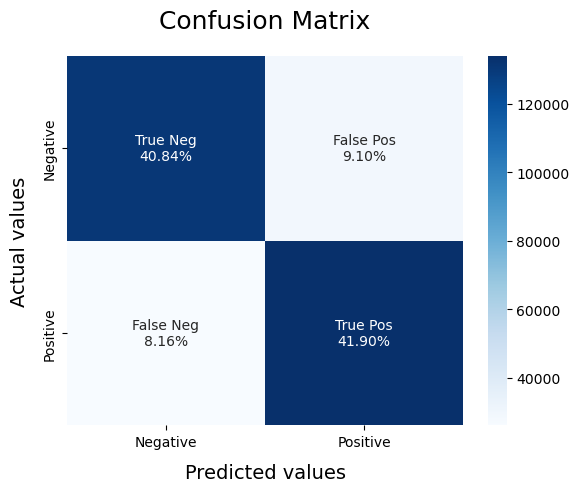

In [133]:
LRmodel = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)

In [134]:
print(LRmodel.score(X_train, y_train))
print(LRmodel.score(X_test, y_test))

0.8714046875
0.827421875


## Inference

**We can clearly see that:**

- The **Logistic Regression model** performs the best out of all the different models that we tried. It achieves **83% test accuracy**.

- This is followed by the **LinearSVC model** with **82% test accuracy** and the **BernoulliNB model** with **80% test accuracy**.

## Saving model

- We will use pickle to save the vectorizer and all models for later use.

In [135]:
file = open("models/vectorizer.pickle","wb")
pickle.dump(vectorizer, file)
file.close()

file = open("models/BNB_model.pickle","wb")
pickle.dump(BNBmodel, file)
file.close()

file = open("models/SVC_model.pickle","wb")
pickle.dump(SVCmodel, file)
file.close()

file = open("models/LR_model.pickle","wb")
pickle.dump(LRmodel, file)
file.close()

## Using model

- To use the model for **sentiment prediction**, we need to import the vectorizer and the given model using pickle.
- The vectorizer can be used to transform data to a matrix of TF-IDF features.
- The model can be used to predict the sentiment of the transformed and preprocessed data.

In [141]:
def load_models():
    # Load the vectorizer
    file = open("models/vectorizer.pickle", "rb")
    vectorizer = pickle.load(file)
    file.close()
    
    # Load the LR model
    file = open("models/LR_model.pickle", "rb")
    LRmodel = pickle.load(file)
    file.close()
    
    # # OPTIONAL - Load and return other models
    # # Load the BNB model
    # file = open("models/BNB_model.pickle", "rb")
    # BNBmodel = pickle.load(file)
    # file.close()
    
    # # Load the SVC model
    # file = open("models/SVC_model.pickle", "rb")
    # SVCmodel = pickle.load(file)
    # file.close()
    
    # return vectorizer, BNBmodel, SVCmodel, LRmodel
    
    return vectorizer, LRmodel

def predict(vectorizer, model, text):
    # Predict the sentiment
    textdata = vectorizer.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text, pred))
    
    # Convert the list into a dataFrame
    df = pd.DataFrame(data, columns = ["text", "sentiment_"])
    df["sentiment"] = df["sentiment_"].replace([0, 1], ["Negative", "Positive"])
    return df

if __name__=="__main__":
    # Loading the vectorizer and model
    vectorizer, LRmodel = load_models()
    
    # Text to classify
    text = ["I am happy",
            "I am sad",
            "I am not happy",
            "I am not sad",
            "This website has gotten worse",
            "The name X makes no sense",
            "You could not live with your own failure and where did that bring you? Back to me"]
    
    df2 = predict(vectorizer, LRmodel, text)
    display(df2)

,text,sentiment_,sentiment
0,I am happy,1,Positive
1,I am sad,0,Negative
2,I am not happy,0,Negative
3,I am not sad,0,Negative
4,This website has gotten worse,0,Negative
5,The name X makes no sense,1,Positive
6,You could not live with your own failure and w...,0,Negative


## Further steps to consider
To expand on our work, we can consider:
- Using other models.
- Cross validating models to tune them further. Note that the data set is very large and this will likely take a very long time to execute.
- Using other metrics like roc-auc score.
- Obtaining data with a third category/class. Eg the tweets could be positive, negative or **neutral**.